### Out of Focus Blur

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def apply_out_of_focus_blur(image, depth_map, blur_strength=21):
    # Ensure the depth map is in the same size as the image
    depth_map = cv2.resize(depth_map, (image.shape[1], image.shape[0]))
    
    # Normalize the depth map to range 0 to 1
    depth_map = depth_map.astype(np.float32) / 255.0

    # Expand the depth map to have three channels
    depth_map_3ch = cv2.merge([depth_map, depth_map, depth_map])

    # Create a blurred version of the image
    blurred_image = cv2.GaussianBlur(image, (blur_strength, blur_strength), 0)

    # Blend the original and blurred image according to the depth map
    blended_image = (1.0 - depth_map_3ch) * image + depth_map_3ch * blurred_image
    blended_image = blended_image.astype(np.uint8)
    
    return blended_image



In [4]:

# Load the image
image = cv2.imread('BMW-M5-Competition.jpg')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)



In [5]:
# Create a depth map (This should ideally come from some depth estimation algorithm)
# For demonstration, we create a simple synthetic depth map
depth_map = np.zeros(image.shape[:2], dtype=np.uint8)
cv2.circle(depth_map, (image.shape[1]//2, image.shape[0]//2), 200, 255, -1)

# Apply out-of-focus blur effect
out_of_focus_image = apply_out_of_focus_blur(image_rgb, depth_map)



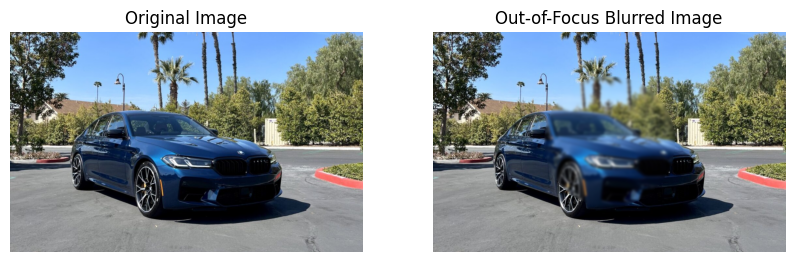

In [6]:
# Display the original and out-of-focus blurred images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image_rgb)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Out-of-Focus Blurred Image')
plt.imshow(out_of_focus_image)
plt.axis('off')

plt.show()

### CENTER FOCUSED Spatially varying Blur

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt



In [9]:

def apply_spatially_varying_blur(image, depth_map, max_blur_strength=25):
    # Ensure the depth map is the same size as the image
    depth_map = cv2.resize(depth_map, (image.shape[1], image.shape[0]))

    # Normalize the depth map to range 0 to 1
    depth_map = depth_map.astype(np.float32) / 255.0

    # Create an empty image to store the result
    result = np.zeros_like(image, dtype=np.float32)

    for blur_strength in range(1, max_blur_strength + 1, 2):
        # Apply Gaussian blur with the current strength
        blurred_image = cv2.GaussianBlur(image, (blur_strength, blur_strength), 0)

        # Calculate the weight for blending based on the depth map
        weight = np.clip(depth_map * max_blur_strength - (blur_strength - 1), 0, 1)
        # Expand weight to have three channels
        weight_3ch = cv2.merge([weight, weight, weight])

        # Blend the blurred image with the result
        result += blurred_image * weight_3ch

    # Blend the original image in areas with low depth values
    weight = np.clip(1.0 - depth_map * max_blur_strength, 0, 1)
    weight_3ch = cv2.merge([weight, weight, weight])
    result += image * weight_3ch

    # Normalize the result to the range [0, 255]
    result = np.clip(result, 0, 255).astype(np.uint8)
    return result


In [10]:

# Load the image
image = cv2.imread('flower.jpeg')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)



In [11]:
# Create a synthetic depth map where the center is in focus
h, w = image.shape[:2]
depth_map = np.zeros((h, w), dtype=np.uint8)
cv2.circle(depth_map, (w//2, h//2), min(w, h)//3, 255, -1)
depth_map = cv2.GaussianBlur(depth_map, (51, 51), 0)
depth_map = 255 - depth_map  # Invert the depth map to blur the edges

# Apply spatially varying blur effect
spatially_varied_blur_image = apply_spatially_varying_blur(image_rgb, depth_map)


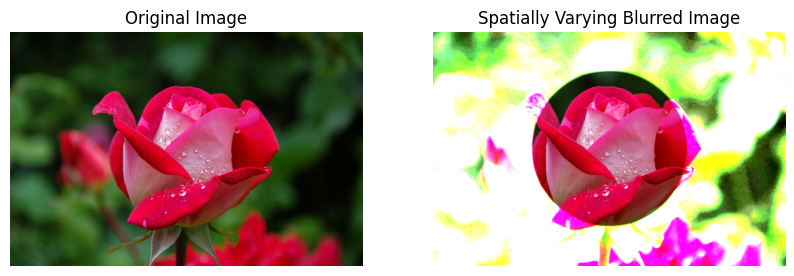

In [12]:

# Display the original and spatially varied blurred images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image_rgb)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Spatially Varying Blurred Image')
plt.imshow(spatially_varied_blur_image)
plt.axis('off')

plt.show()

### Turbulence blur

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt



In [3]:

def generate_turbulence_map(shape, frequency=10, amplitude=10):
    """Generate a turbulence map with the given shape."""
    rows, cols = shape[:2]
    x = np.linspace(0, frequency * 2 * np.pi, cols)
    y = np.linspace(0, frequency * 2 * np.pi, rows)
    X, Y = np.meshgrid(x, y)
    
    # Generate turbulence map
    turbulence_x = amplitude * np.sin(X) 
    turbulence_y = amplitude * np.cos(Y)
    
    return turbulence_x, turbulence_y


In [4]:

def apply_turbulence_blur(image, turbulence_x, turbulence_y):
    """Apply turbulence blur using the displacement map."""
    rows, cols, _ = image.shape
    map_x, map_y = np.meshgrid(np.arange(cols), np.arange(rows))
    
    # Create the displacement map
    displacement_map_x = np.clip(map_x + turbulence_x, 0, cols - 1)
    displacement_map_y = np.clip(map_y + turbulence_y, 0, rows - 1)
    
    # Remap the image using the displacement map
    displaced_image = cv2.remap(image, displacement_map_x.astype(np.float32), displacement_map_y.astype(np.float32), interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
    
    return displaced_image


In [5]:

def degrade_image(image_path):
    # Read the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

    # Generate turbulence map
    turbulence_x, turbulence_y = generate_turbulence_map(image.shape, frequency=10, amplitude=10)

    # Apply turbulence blur
    turbulence_blurred_image = apply_turbulence_blur(image, turbulence_x, turbulence_y)

    # Display the images
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(image)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title('Turbulence Blurred Image')
    plt.imshow(turbulence_blurred_image)
    plt.axis('off')
    
    plt.show()


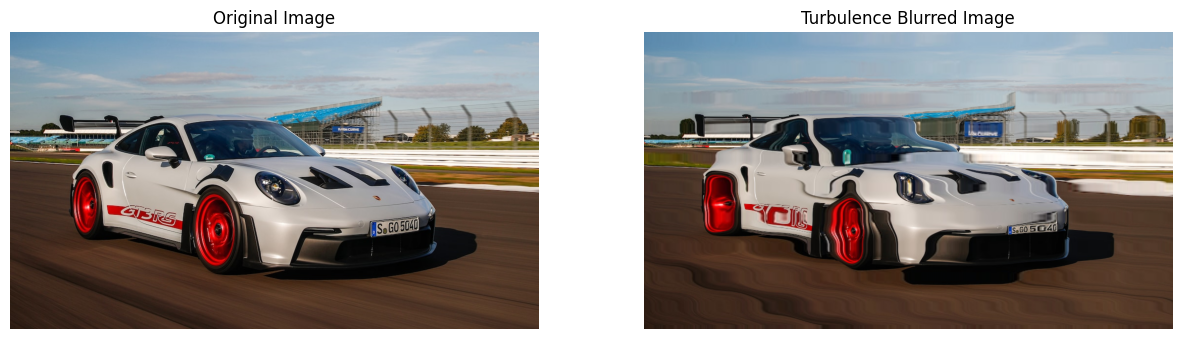

In [6]:

image_path = 'GT3-RS.jpg'
degrade_image(image_path)

## Degrade an image and restore using inverse filtering

In [58]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [59]:
def apply_gaussian_blur(image, kernel_size=5):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

In [60]:
def apply_salt_and_pepper_noise(image, salt_prob=0.01, pepper_prob=0.01):
    noisy = np.copy(image)
    salt = np.random.rand(*image.shape) < salt_prob
    pepper = np.random.rand(*image.shape) < pepper_prob
    noisy[salt] = 255
    noisy[pepper] = 0
    return noisy

In [66]:
def degrade_image(image_path):
    # Read the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

    # Apply Gaussian blur
    gaussian_blurred_image = apply_gaussian_blur(image, kernel_size=15)

    # Apply salt and pepper noise
    degraded_image = apply_salt_and_pepper_noise(gaussian_blurred_image, salt_prob=0.05, pepper_prob=0.05)

    # Save the degraded image
    cv2.imwrite('degraded_image.jpg', cv2.cvtColor(degraded_image, cv2.COLOR_RGB2BGR))

    # Display the images
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(image)
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title('Gaussian Blurred Image')
    plt.imshow(gaussian_blurred_image)
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.title('Degraded Image (Gaussian Blur + Salt and Pepper Noise)')
    plt.imshow(degraded_image)
    plt.axis('off')
    
    plt.show()

In [62]:
def inverse_filtering(degraded_image, kernel, eps=1e-3):
    dft_degraded = np.fft.fft2(degraded_image)
    dft_degraded_shift = np.fft.fftshift(dft_degraded)

    kernel_padded = np.zeros_like(degraded_image)
    kh, kw = kernel.shape
    kernel_padded[:kh, :kw] = kernel

    dft_kernel = np.fft.fft2(kernel_padded)
    dft_kernel_shift = np.fft.fftshift(dft_kernel)

    # Avoid division by zero
    dft_kernel_shift[dft_kernel_shift == 0] = eps

    restored_dft = dft_degraded_shift / dft_kernel_shift
    restored_dft_shift = np.fft.ifftshift(restored_dft)
    restored_image = np.fft.ifft2(restored_dft_shift)
    restored_image = np.abs(restored_image)
    return restored_image

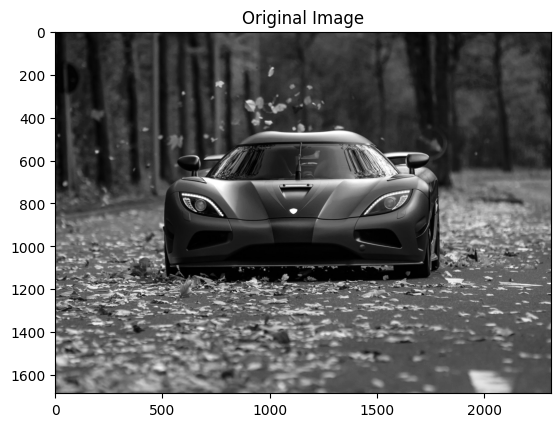

In [63]:
# Load an image in grayscale
image = cv2.imread('car.jpg', cv2.IMREAD_GRAYSCALE)

# Display the original image
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.show()

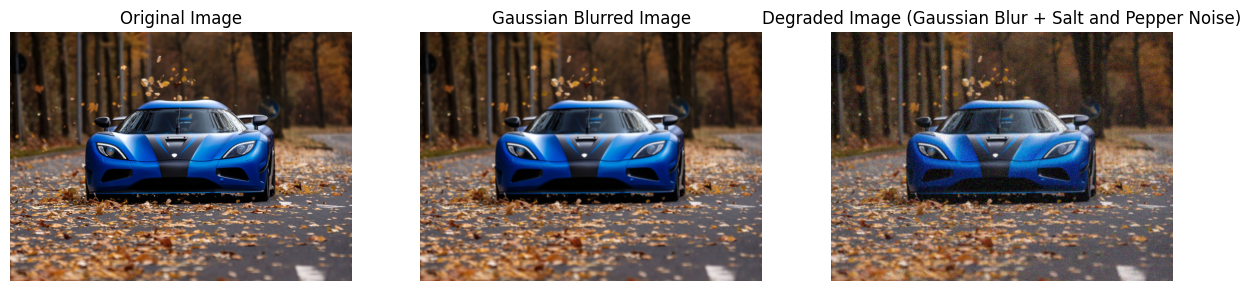

In [64]:
degrade_image('car.jpg')

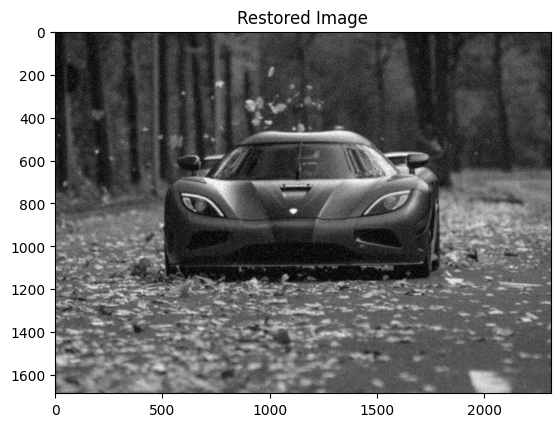

In [67]:
# Define Gaussian kernel
kernel_size = 5
sigma = 1.0
gaussian_kernel = cv2.getGaussianKernel(kernel_size, sigma)
gaussian_kernel = gaussian_kernel * gaussian_kernel.T

noisy_image = cv2.imread('degraded_image.jpg', cv2.IMREAD_GRAYSCALE)

# Restore the image using inverse filtering
restored_image = inverse_filtering(noisy_image, gaussian_kernel)

# Display the restored image
plt.imshow(restored_image, cmap='gray')
plt.title('Restored Image')
plt.show()

## Generate a synthetic image, degrade it and restore using inverse filtering

In [69]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [77]:
def generate_synthetic_image(size=256):
    image = np.zeros((size, size), dtype=np.uint8)
    cv2.circle(image, (int((size, size)[1]/2), int((size, size)[0]/2)), 50, (255, 255, 255), -1)
    cv2.rectangle(image, (100, 100), (200, 200), (128, 128, 128), -1)
    return image

synthetic_image = generate_synthetic_image()

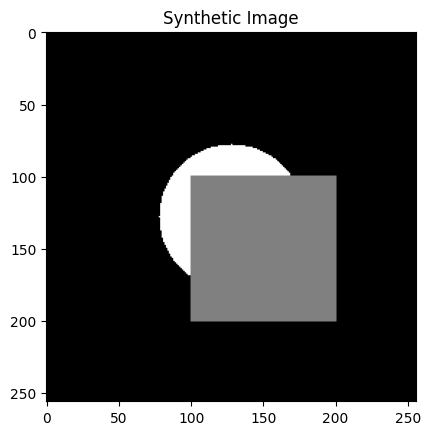

In [78]:
# Display the synthetic image
plt.imshow(synthetic_image, cmap='gray')
plt.title('Synthetic Image')
plt.show()

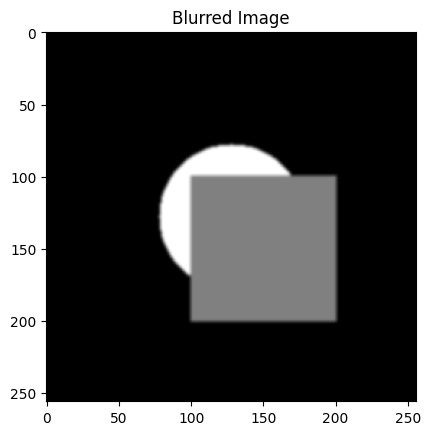

In [79]:
def apply_gaussian_blur(image, kernel_size=5):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

blurred_image = apply_gaussian_blur(synthetic_image, kernel_size=5)

# Display the blurred image
plt.imshow(blurred_image, cmap='gray')
plt.title('Blurred Image')
plt.show()

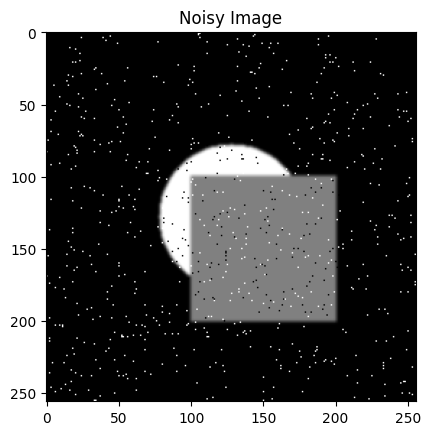

In [80]:
def add_salt_and_pepper_noise(image, salt_prob=0.01, pepper_prob=0.01):
    noisy = np.copy(image)
    salt = np.random.rand(*image.shape) < salt_prob
    pepper = np.random.rand(*image.shape) < pepper_prob
    noisy[salt] = 255
    noisy[pepper] = 0
    return noisy

noisy_image = add_salt_and_pepper_noise(blurred_image, salt_prob=0.01, pepper_prob=0.01)

# Display the noisy image
plt.imshow(noisy_image, cmap='gray')
plt.title('Noisy Image')
plt.show()

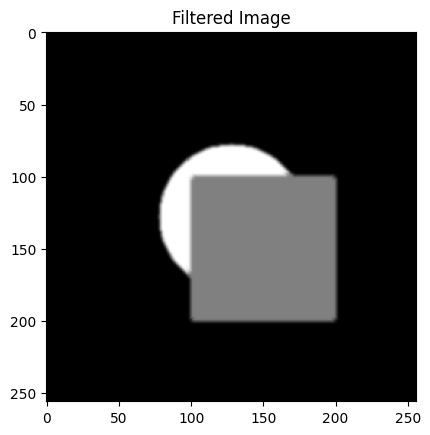

In [81]:
def apply_median_filter(image, kernel_size=5):
    return cv2.medianBlur(image, kernel_size)

filtered_image = apply_median_filter(noisy_image, kernel_size=5)

# Display the filtered image
plt.imshow(filtered_image, cmap='gray')
plt.title('Filtered Image')
plt.show()

In [82]:
def inverse_filtering(degraded_image, kernel, eps=1e-3):
    dft_degraded = np.fft.fft2(degraded_image)
    dft_degraded_shift = np.fft.fftshift(dft_degraded)

    kernel_padded = np.zeros_like(degraded_image)
    kh, kw = kernel.shape
    kernel_padded[:kh, :kw] = kernel

    dft_kernel = np.fft.fft2(kernel_padded)
    dft_kernel_shift = np.fft.fftshift(dft_kernel)

    # Avoid division by zero
    dft_kernel_shift[dft_kernel_shift == 0] = eps

    restored_dft = dft_degraded_shift / dft_kernel_shift
    restored_dft_shift = np.fft.ifftshift(restored_dft)
    restored_image = np.fft.ifft2(restored_dft_shift)
    restored_image = np.abs(restored_image)
    return restored_image

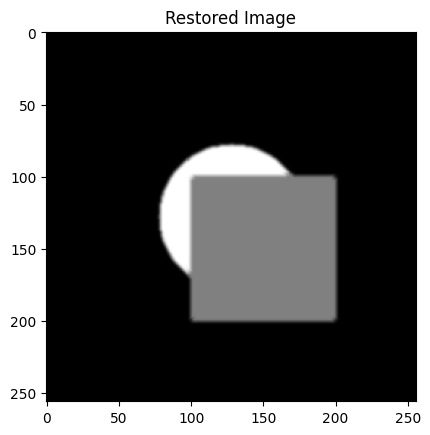

In [83]:
# Define Gaussian kernel
kernel_size = 5
sigma = 1.0
gaussian_kernel = cv2.getGaussianKernel(kernel_size, sigma)
gaussian_kernel = gaussian_kernel * gaussian_kernel.T

# Restore the image using inverse filtering
restored_image = inverse_filtering(filtered_image, gaussian_kernel)

# Display the restored image
plt.imshow(restored_image, cmap='gray')
plt.title('Restored Image')
plt.show()

## Degrade an image and restore using wiener filtering

In [84]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

In [85]:
def wiener_filter(image, kernel, noise_var, estimated_noise_var):
    """Apply Wiener filter to the image."""
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    kernel_ft = fft2(kernel, s=image.shape)
    image_ft = fft2(image)

    # Compute the power spectrum of the image
    image_power = np.abs(image_ft) ** 2
    kernel_power = np.abs(kernel_ft) ** 2

    # Wiener filter
    wiener_filter = np.conj(kernel_ft) / (kernel_power + noise_var / estimated_noise_var)
    restored_image_ft = image_ft * wiener_filter

    # Inverse Fourier transform
    restored_image = np.abs(ifft2(restored_image_ft))
    
    return restored_image

In [86]:
def generate_gaussian_kernel(kernel_size, sigma):
    """Generate a Gaussian kernel."""
    kernel = np.fromfunction(
        lambda x, y: np.exp(-((x - kernel_size // 2) ** 2 + (y - kernel_size // 2) ** 2) / (2 * sigma ** 2)),
        (kernel_size, kernel_size)
    )
    kernel = kernel / np.sum(kernel)
    return kernel

In [87]:
def process_and_restore_image(image_path):
    # Read the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

    # Parameters
    kernel_size = 15
    sigma = kernel_size / 6
    noise_var = 0.01
    estimated_noise_var = 0.02

    # Generate Gaussian kernel
    kernel = generate_gaussian_kernel(kernel_size, sigma)

    # Apply Gaussian blur to simulate degradation
    blurred_image = convolve2d(image[:, :, 0], kernel, mode='same', boundary='wrap')
    
    # Add salt and pepper noise to the image
    noisy_image = add_salt_and_pepper_noise(image, salt_prob=0.05, pepper_prob=0.05)

    # Apply Wiener filtering
    restored_image = wiener_filter(noisy_image, kernel, noise_var, estimated_noise_var)

    # Display the images
    plt.figure(figsize=(15, 10))
    plt.subplot(1, 3, 1)
    plt.title('Noisy Image')
    plt.imshow(noisy_image)
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title('Restored Image (Wiener Filter)')
    plt.imshow(restored_image, cmap='gray')
    plt.axis('off')

    plt.show()

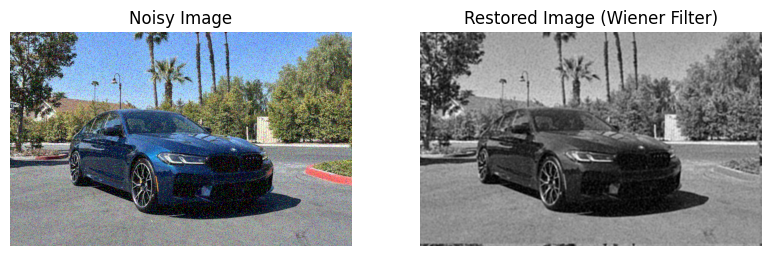

In [89]:
# Path to the input image
image_path = 'BMW-M5-Competition.jpg'
process_and_restore_image(image_path)


## Degrade an image and restore using CLS - Constrained least squares

In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [8]:
def display_image(image, title):
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

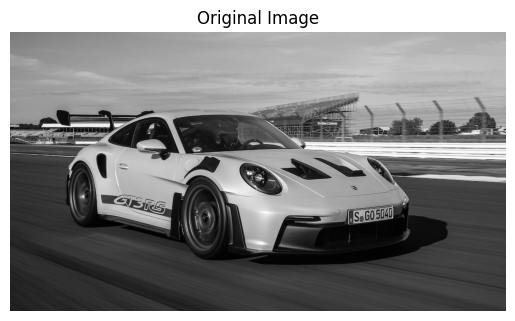

In [9]:
image_path = 'GT3-RS.jpg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
# Display the original image
display_image(image, 'Original Image')

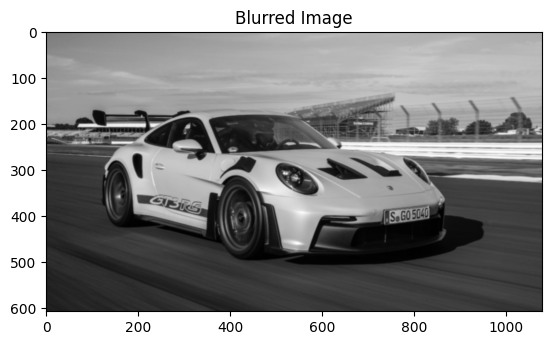

In [10]:
def apply_gaussian_blur(image, kernel_size=5):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

blurred_image = apply_gaussian_blur(image, kernel_size=5)

# Display the blurred image
plt.imshow(blurred_image, cmap='gray')
plt.title('Blurred Image')
plt.show()

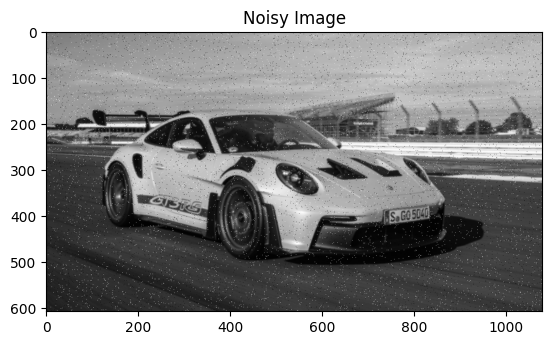

In [11]:
def add_salt_and_pepper_noise(image, salt_prob=0.01, pepper_prob=0.01):
    noisy = np.copy(image)
    salt = np.random.rand(*image.shape) < salt_prob
    pepper = np.random.rand(*image.shape) < pepper_prob
    noisy[salt] = 255
    noisy[pepper] = 0
    return noisy

noisy_image = add_salt_and_pepper_noise(blurred_image, salt_prob=0.01, pepper_prob=0.01)

# Display the noisy image
plt.imshow(noisy_image, cmap='gray')
plt.title('Noisy Image')
plt.show()

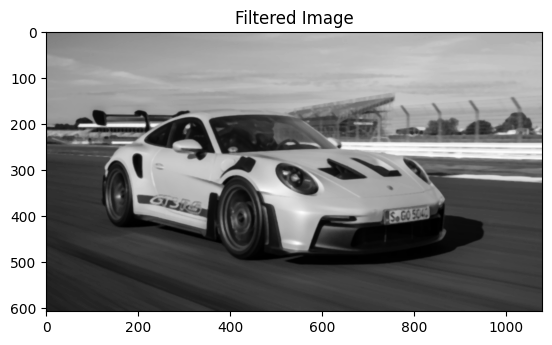

In [12]:
def apply_median_filter(image, kernel_size=5):
    return cv2.medianBlur(image, kernel_size)

filtered_image = apply_median_filter(noisy_image, kernel_size=5)

# Display the filtered image
plt.imshow(filtered_image, cmap='gray')
plt.title('Filtered Image')
plt.show()

In [13]:
def cls_filter(degraded_image, kernel, gamma, eps=1e-3):
    dft_degraded = np.fft.fft2(degraded_image)
    dft_degraded_shift = np.fft.fftshift(dft_degraded)

    kernel_padded = np.zeros_like(degraded_image)
    kh, kw = kernel.shape
    kernel_padded[:kh, :kw] = kernel

    dft_kernel = np.fft.fft2(kernel_padded)
    dft_kernel_shift = np.fft.fftshift(dft_kernel)

    # Generate Laplacian filter in frequency domain
    laplacian = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
    laplacian_padded = np.zeros_like(degraded_image)
    lh, lw = laplacian.shape
    laplacian_padded[:lh, :lw] = laplacian

    dft_laplacian = np.fft.fft2(laplacian_padded)
    dft_laplacian_shift = np.fft.fftshift(dft_laplacian)

    # CLS filtering in frequency domain
    h_conj = np.conj(dft_kernel_shift)
    denominator = np.abs(dft_kernel_shift) ** 2 + gamma * np.abs(dft_laplacian_shift) ** 2
    denominator[denominator == 0] = eps
    dft_restored = (h_conj / denominator) * dft_degraded_shift

    restored_dft_shift = np.fft.ifftshift(dft_restored)
    restored_image = np.fft.ifft2(restored_dft_shift)
    restored_image = np.abs(restored_image)
    restored_image = np.clip(restored_image, 0, 255).astype(np.uint8)
    return restored_image

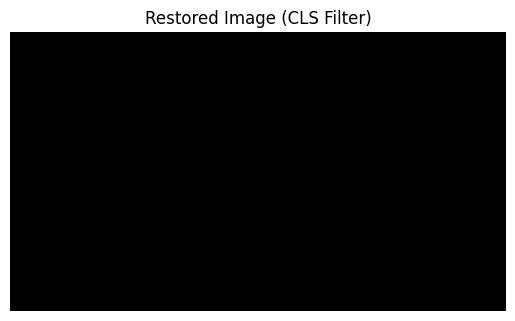

In [14]:
# Define Gaussian kernel
kernel_size = 5
sigma = 1.0
gaussian_kernel = cv2.getGaussianKernel(kernel_size, sigma)
gaussian_kernel = gaussian_kernel * gaussian_kernel.T

# Restore the image using CLS filtering
gamma = 0.001
restored_image_cls = cls_filter(filtered_image, gaussian_kernel, gamma)

# Display the restored image
display_image(restored_image_cls, 'Restored Image (CLS Filter)')